# Groundwater transport modeling
---

*Notebook developed by D.A. Brakenhoff*


This notebook shows how `nlmod` can be used to set up a groundwater transport
model. In this example we create a model of a coastal area in the Netherlands
where density driven flow caused by the higher salinity of sea water affects
the heads.

In [1]:
# import packages
import nlmod
import xarray as xr
import flopy as fp
import matplotlib.pyplot as plt

# set up pretty logging and show package versions
nlmod.util.get_color_logger("INFO");
nlmod.show_versions()

Python version: 3.9.7
NumPy version: 1.21.2
Xarray version: 2022.10.0
Matplotlib version: 3.7.0

nlmod version: 0.5.2b


Set model settings. 

Note that we set `transport` to True. This variable is passed
to the model dataset constructor and indicates that we're building a transport
model. This attribute is used by `nlmod` when writing modflow packages so that
it is aware that we're working on a transport model.

In [2]:
# model settings
model_ws = "hondsbossche"
model_name = "hondsbossche"

figdir, cachedir = nlmod.util.get_model_dirs(model_ws)

extent_hbossche = [103700, 106700, 527500, 528500]

delr = 100.0
delc = 100.0

add_northsea = True
transport = True

start_time = "2010-1-1"
starting_head = 1.0

Plot the model area.

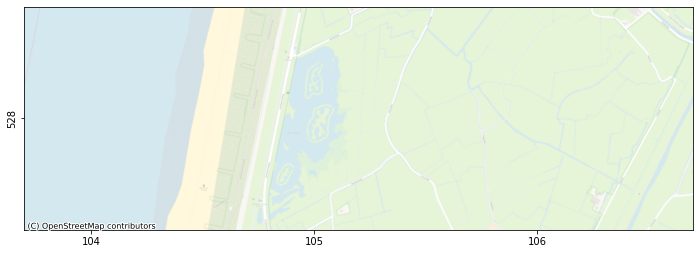

In [3]:
fig, ax = nlmod.plot.get_map(extent_hbossche, background="OpenStreetMap.Mapnik")

Download REGIS and GeoTOP in our model area and combine the two to create a
layer model. Next convert this layer model into a model dataset using grid
information using `nlmod.to_model_ds`. 

Then we add time discretization, add the north sea to our layer model, and set
default transport parameters for our transport model. 

The last step is done with
`nlmod.gwt.prepare.set_default_transport_parameters`. In this case we're using
chloride concentrations to model salinity effects, so we've set default
parameters values for that case.

In [4]:
layer_model = nlmod.read.regis.get_combined_layer_models(
    extent_hbossche,
    use_regis=True,
    regis_botm_layer="MSz1",
    use_geotop=True,
    cachedir=cachedir,
    cachename="combined_layer_ds.nc",
)

# create a model ds
ds = nlmod.to_model_ds(
    layer_model,
    model_name,
    model_ws,
    delr=delr,
    delc=delc,
    transport=transport,
)

# add time discretisation
ds = nlmod.time.set_ds_time(
    ds,
    start_time=start_time,
    steady_state=False,
    steady_start=True,
    steady_start_perlen=1,
    transient_timesteps=10,
    perlen=365.,
)

if add_northsea:
    ds = nlmod.read.rws.add_northsea(ds, cachedir=cachedir)

if ds.transport == 1:
    ds = nlmod.gwt.prepare.set_default_transport_parameters(ds, transport_type="chloride")

INFO:nlmod.cache:using cached data -> combined_layer_ds.nc
INFO:nlmod.dims.base:resample layer model data to structured modelgrid
INFO:nlmod.read.rws:nan values at the northsea are filled using the bathymetry from jarkus
INFO:nlmod.cache:using cached data -> sea_ds.nc
INFO:nlmod.cache:using cached data -> bathymetry_ds.nc


Next we load chloride concentrations for our model. These are obtained from the
NHI salinity dataset, where chloride concentrations for the Netherlands were
determined based on observations and modeling. The full dataset `3dchlorde.nc`
can be downloaded from here: https://zenodo.org/record/7419219. Here we load a
small dataset that was extracted from the full dataset.

This dataset does not match our model grid, so we use nearest interpolation get
the chloride concentration for each of our model cells.

In [5]:
# cl = xr.open_dataset("../../../pwn_diep/data/3dchloride_result.nc")
cl = xr.open_dataset("./data/chloride_hbossche.nc")


# interpolate to modelgrid using nearest
cli = cl.sel(percentile="p50").interp(x=ds.x, y=ds.y, method="nearest")
cli

<xarray.Dataset>
Dimensions:      (layer: 46, y: 10, x: 30)
Coordinates:
    percentile   <U3 'p50'
  * layer        (layer) int32 1 2 3 4 5 6 7 8 9 ... 38 39 40 41 42 43 44 45 46
    z            (layer) float64 110.0 80.0 50.0 40.0 ... -280.0 -300.0 -500.0
    dz           (layer) float64 30.0 30.0 20.0 10.0 ... 20.0 20.0 110.0 200.0
    top          (layer) float64 125.0 95.0 65.0 45.0 ... -270.0 -290.0 -400.0
    bottom       (layer) float64 95.0 65.0 45.0 35.0 ... -290.0 -400.0 -600.0
    dy           float64 -250.0
    dx           float64 250.0
  * x            (x) float64 1.038e+05 1.038e+05 ... 1.066e+05 1.066e+05
  * y            (y) float64 5.284e+05 5.284e+05 ... 5.276e+05 5.276e+05
Data variables:
    3d-chloride  (layer, y, x) float64 nan nan nan ... 1.529e+04 1.529e+04

The chloride concentration dataset also does not have the same vertical
discretization as our model. In order to calculate the mean concentration in
each cell in every layer of our model we use
`nlmod.layers.aggregate_by_weighted_mean_to_ds` to calculate the weighted mean
of the chloride concentration observations in each layer. We also fill the NaNs
in the resulting dataset using nearest interpolation.

Finally, we add this chloride data array to our model dataset, which now has a
chloride concentration for each cell in our model.

In [6]:
# aggregate chloride to our layer model using weighted mean
cli_da = nlmod.layers.aggregate_by_weighted_mean_to_ds(ds, cli, "3d-chloride")

# interpolate NaNs nearest
for ilay in range(cli_da.shape[0]):
    cli_da.values[ilay] = nlmod.resample.fillnan_da(
        da=cli_da.isel(layer=ilay), method="nearest"
    )

# set chloride data in model dataset
ds["chloride"] = cli_da

Now we can start building our groundwater model. We start with the Simulation object,
time discretization and IMS solver.

In [7]:
# create simulation
sim = nlmod.sim.sim(ds)

# create time discretisation
tdis = nlmod.sim.tdis(ds, sim)

# create ims
ims = nlmod.sim.ims(sim, complexity="MODERATE")

INFO:nlmod.sim.sim:creating modflow SIM
INFO:nlmod.sim.sim:creating modflow TDIS
INFO:nlmod.sim.sim:creating modflow IMS


Next we add the groundwater flow model.

In [8]:
# create groundwater flow model
gwf = nlmod.gwf.gwf(ds, sim)

# Create discretization
dis = nlmod.gwf.dis(ds, gwf)

# create node property flow
npf = nlmod.gwf.npf(ds, gwf)

# create storage
sto = nlmod.gwf.sto(ds, gwf)

# Create the initial conditions package
ic = nlmod.gwf.ic(ds, gwf, starting_head=starting_head)

# Create the output control package
oc = nlmod.gwf.oc(ds, gwf)

INFO:nlmod.gwf.gwf:creating modflow GWF
INFO:nlmod.gwf.gwf:creating modflow DIS
INFO:nlmod.gwf.gwf:creating modflow NPF
INFO:nlmod.gwf.gwf:creating modflow STO
INFO:nlmod.gwf.gwf:creating modflow IC
INFO:nlmod.gwf.gwf:creating modflow OC


We add general head boundaries to model the North Sea. We want to provide the
North Sea with a chloride concentration of 18,000 mgCl-/L. This can be done by
passing this value to the auxiliary keyword argument.

Note that it is also possible to reference one (or more) data arrays from the
model dataset as the auxiliary variable.

If an auxiliary variable is provided and the transport attribute of the model
dataset is 1 (True), `nlmod` automatically registers the GHB package in the
`ssm_sources` attribute, which indicates that we need to add this package as a
source (or sink) for our transport model.

In [9]:
# voeg grote oppervlaktewaterlichamen toe o.b.v. shapefile
da_name = "rws_oppwater"
rws_ds = nlmod.read.rws.get_surface_water(
    ds, da_name, cachedir=ds.cachedir, cachename=da_name
)
# add data to model dataset
ds.update(rws_ds)

# build ghb package
ghb = nlmod.gwf.ghb(ds, gwf, da_name, auxiliary=18_000.0)

INFO:nlmod.cache:using cached data -> rws_oppwater.nc
INFO:nlmod.gwf.gwf:creating modflow GHB


In [10]:
# note that building the GHB added the package to the ssm_sources attribute
ds.ssm_sources

['ghb']

Add surface level drains to the model based on the digital elevetion model AHN.

In [11]:
# surface level drain
ahn_ds = nlmod.read.ahn.get_ahn(ds, cachedir=ds.cachedir, cachename="ahn")
# add data to model dataset
ds.update(ahn_ds)

# build surface level drain package
drn = nlmod.gwf.surface_drain_from_ds(ds, gwf, resistance=10.0)

INFO:nlmod.cache:coordinate x has different values in cached dataset, not using cache


INFO:nlmod.cache:caching data -> ahn.nc


Add recharge based on timeseries measured at meteorolgical stations by KNMI. 

In [12]:
# download knmi recharge data
knmi_ds = nlmod.read.knmi.get_recharge(ds, cachedir=ds.cachedir, cachename="recharge")
# update model dataset
ds.update(knmi_ds)

# create recharge package
rch = nlmod.gwf.rch(ds, gwf, mask=ds["rws_oppwater_cond"] == 0)

INFO:nlmod.cache:using cached data -> recharge.nc
INFO:nlmod.gwf.gwf:creating modflow RCH


Building ts packages rch: 100%|██████████| 1/1 [00:00<00:00, 216.32it/s]


Next, the transport model is created. Note the following steps:

- The buoyancy (BUY) package is added to the groundwater flow model to take
into account density effects.
- The transport model requires its own IMS solver, which also needs to be
registered in the simulation.
- The advection (ADV), dispersion (DSP), mass-storage transfer (MST) and
source-sink mixing (SSM) packages each obtain information from the model
dataset. These variables were defined by
nlmod.gwt.prepare.set_default_transport_parameters`. They can be also be
modified or added to the dataset by the user. Another option is to directly
pass the variables to the package constructors, in which case the stored values
are ignored.

In [13]:
if ds.transport:
    # BUY: buoyancy package for GWF model
    buy = nlmod.gwf.buy(ds, gwf)

    # GWT: groundwater transport model
    gwt = nlmod.gwt.gwt(ds, sim)

    # add IMS for GWT model and register it
    ims = nlmod.sim.ims(sim, pname="ims_gwt", filename=f"{gwt.name}.ims")
    nlmod.sim.register_ims_package(sim, gwt, ims)

    # DIS: discretization package
    dis_gwt = nlmod.gwt.dis(ds, gwt)

    # IC: initial conditions package
    ic_gwt = nlmod.gwt.ic(ds, gwt, "chloride")

    # ADV: advection package
    adv = nlmod.gwt.adv(ds, gwt)

    # DSP: dispersion package
    dsp = nlmod.gwt.dsp(ds, gwt)

    # MST: mass transfer package
    mst = nlmod.gwt.mst(ds, gwt)

    # SSM: source-sink mixing package
    ssm = nlmod.gwt.ssm(ds, gwt)

    # OC: output control
    oc_gwt = nlmod.gwt.oc(ds, gwt)

    # GWF-GWT Exchange
    gwfgwt = nlmod.gwt.gwfgwt(ds, sim)

INFO:nlmod.gwt.gwt:creating modflow GWT
INFO:nlmod.sim.sim:creating modflow IMS
INFO:nlmod.gwf.gwf:creating modflow DIS
INFO:nlmod.gwt.gwt:creating modflow IC
INFO:nlmod.gwt.gwt:creating modflow ADV
INFO:nlmod.gwt.gwt:creating modflow DSP
INFO:nlmod.gwt.gwt:creating modflow MST
INFO:nlmod.gwt.gwt:creating modflow SSM
INFO:nlmod.gwt.gwt:creating modflow OC
INFO:nlmod.gwt.gwt:creating modflow exchange GWFGWT


Now write the model files and run the simulation.

In [14]:
nlmod.sim.write_and_run(sim, ds)

INFO:nlmod.sim.sim:write model dataset to cache
INFO:nlmod.sim.sim:write modflow files to model workspace
writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims...
  writing solution package ims_gwt...
  writing package hondsbossche.gwfgwt...
  writing model hondsbossche...
    writing model name file...
    writing package dis...
    writing package npf...
    writing package sto...
    writing package ic...
    writing package oc...
    writing package ghb...
    writing package drn...
    writing package rch...
    writing package ts_0...
    writing package buy...
  writing model hondsbossche_gwt...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package adv...
    writing package dsp...
    writing package mst...
    writing package ssm...
    writing package oc...
INFO:nlmod.sim.sim:run model
FloPy is using the following executable to run the model: ../../../nlmod/

Visualize the model input, specifically the boundary conditions.

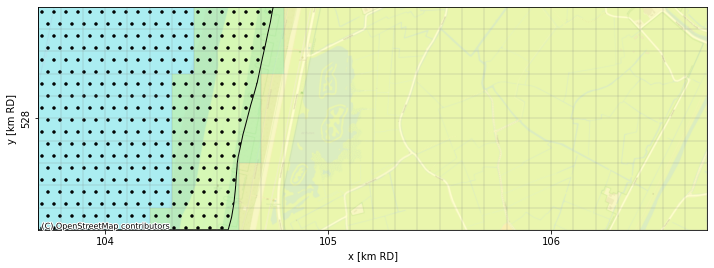

In [15]:
# plot using flopy
fig, ax = nlmod.plot.get_map(extent_hbossche, background="OpenStreetMap.Mapnik")
pmv = fp.plot.PlotMapView(model=gwf, layer=0, ax=ax)
# pc = pmv.plot_array(c.isel(time=0), cmap="Spectral_r")
pmv.plot_bc("GHB", plotAll=True, alpha=0.1, label="GHB")
pmv.plot_bc("DRN", plotAll=True, alpha=0.1, label="DRN")
# pmv.plot_bc("RCH", plotAll=True, alpha=0.1, label="RCH")
nlmod.plot.surface_water(ds, ax=ax, hatch=".", edgecolor="k", facecolor="none", label="North Sea")
pmv.plot_grid(linewidth=0.25);
ax.set_xlabel("x [km RD]")
ax.set_ylabel("y [km RD]");

Load the calculated heads and concentrations.

In [16]:
h = nlmod.gwf.output.get_heads_da(ds)
c = nlmod.gwt.output.get_concentration_da(ds)

# calculate concentration at groundwater surface
ctop = nlmod.gwt.get_concentration_at_gw_surface(c)

Plot the concentration at groundwater surface level.

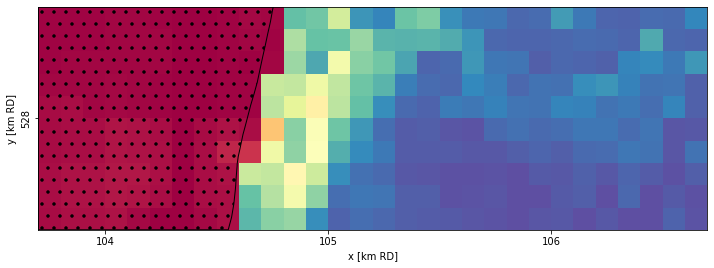

In [17]:
fig, ax = nlmod.plot.get_map(extent_hbossche)
nlmod.plot.data_array(ctop.isel(time=-1), ds=ds, ax=ax, cmap="Spectral_r")
nlmod.plot.surface_water(ds, ax=ax, hatch=".", edgecolor="k", facecolor="none")
ax.set_xlabel("x [km RD]")
ax.set_ylabel("y [km RD]");

Plot a cross-section along (x) showing the calculated concentration in the model.

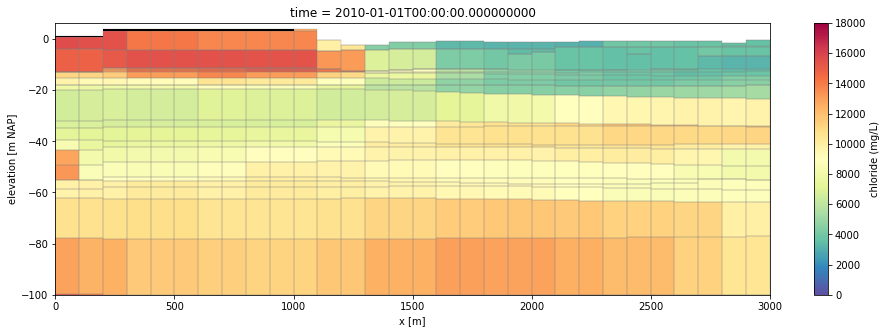

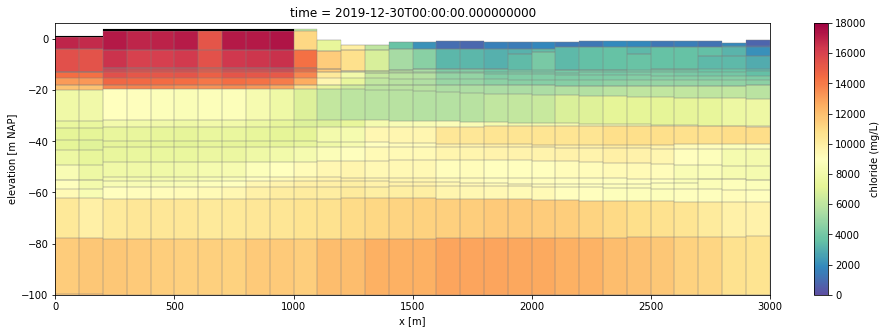

In [18]:
y = (ds.extent[2] + ds.extent[3]) / 2 + 0.1
line = [(ds.extent[0], y), (ds.extent[1], y)]
zmin = -150.0
zmax = 10.0

for time_idx in [0, -1]:
    # plot using flopy
    fig, ax = plt.subplots(1, 1, figsize=(16, 5))
    pmv = fp.plot.PlotCrossSection(model=gwf, line={"line": line})
    pc = pmv.plot_array(c.isel(time=time_idx), cmap="Spectral_r", vmin=0.0, vmax=18_000.)
    pmv.plot_bc("GHB", color="k", zorder=10)
    pmv.plot_grid(linewidth=0.25)
    cbar = fig.colorbar(pc, ax=ax)
    cbar.set_label("chloride (mg/L)")
    ax.set_ylim(bottom=-100)
    ax.set_xlabel("x [m]")
    ax.set_ylabel("elevation [m NAP]")
    ax.set_title(f"time = {c.time.isel(time=time_idx).values}");

Converting calculated heads (which represent point water heads) to equivalent
freshwater heads, and vice versa, can be done with the following functions in `nlmod`.

In [20]:
hf = nlmod.gwt.output.freshwater_head(ds, h, c)
hp = nlmod.gwt.output.pointwater_head(ds, hf, c)